In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Derived from Motion Parameters

### 1. Magnitude of Acceleration
- **Definition**: Combines the X, Y, and Z components of linear acceleration into a single value representing the overall acceleration magnitude.
- **Formula**:
  $$
  \color{green}{\text{magnitude\_acceleration} = \sqrt{a_x^2 + a_y^2 + a_z^2}}
  $$
- **Purpose**: Useful for detecting sudden changes in motion during a fall.

In [ ]:
def compute_acceleration_magnitude(ax, ay, az):
    return np.sqrt(ax**2 + ay**2 + az**2)

### 2. Magnitude of Angular Velocity
- **Definition**: Combines the X, Y, and Z components of angular velocity into a single value representing the overall rotational speed.
- **Formula**:
  $$
  \color{green}{\text{magnitude\_angular\_velocity} = \sqrt{\omega_x^2 + \omega_y^2 + \omega_z^2}}
  $$
- **Purpose**: Useful for detecting rapid spins or tipping movements during a fall.

In [ ]:
def compute_angular_magnitude(wx, wy, wz):
    return np.sqrt(wx**2 + wy**2 + wz**2)

### 3. Tilt Angles :  Computes the tilt of the wheelchair in terms of:
- **Pitch**: Rotation around the X-axis.
  
  - **Formula**:
$$
\color{green}{
\theta_{\text{pitch}} = \arctan2(a_y, \sqrt{a_x^2 + a_z^2})
}
$$


- **Roll**: Rotation around the Y-axis.
  - **Formula**:
$$
\color{green}{
\theta_{\text{roll}} = \arctan2(-a_x, a_z)
}
$$


- **Derivation**:
  - Based on the absolute orientation values, typically using trigonometric functions.
- **Purpose**: Indicates if the wheelchair has tilted beyond a safe threshold, suggesting a fall.

In [ ]:
def compute_pitch(ax, ay, az):
    return np.arctan2(ay, np.sqrt(ax**2 + az**2))

def compute_roll(ax, az):
    return np.arctan2(-ax, az)

#### 2. **Tilted Sideways Detection**

$$
\text{Sideways Tilt} = |\theta_{\text{roll}}| > \theta_{\text{threshold}}
$$
Threshold for detecting a sideways tilt (typically 45-60 degrees).  

---

#### 2. **Tilted Forward/Backward Detection**

$$
\text{Forward/Backward Tilt} = |\theta_{\text{pitch}}| > \theta_{\text{threshold}}
$$
 Threshold for detecting forward/backward tilt (typically 45-60 degrees).  

---

#### 3. **Completely Horizontal Detection**

$$
\text{Horizontal} = (|\theta_{\text{roll}}| < \delta) \land (|\theta_{\text{pitch}}| < \delta)
$$

 Small angle threshold (typically 10-15 degrees).
 This detection is useful for confirming that the box is in its intended position and stable. It can help ensure that small movements or vibrations do not result in an unnecessary alert. This can also be used as a baseline check before triggering other actions or warnings.

---


### 4. Jerk
- **Definition**: Measures the rate of change of linear acceleration over time, highlighting abrupt or jerky movements.
- **Formula**:
  $$
  \color{green}{\text{jerk} = \frac{\Delta a}{\Delta t}}
  $$
- **Purpose**: Useful for identifying sudden, high-acceleration events

In [ ]:
def compute_jerk(a_prev, a_curr, delta_t):
    """
    Compute the jerk (rate of change of acceleration).
    jerk = (a_curr - a_prev) / delta_t
    """
    return (a_curr - a_prev) / delta_t

# Threshhold Diagram

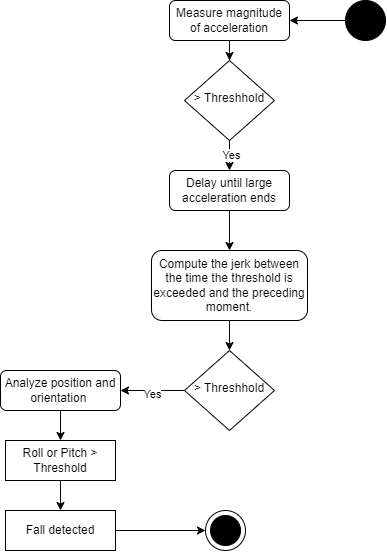

Fall period: 12 to 18


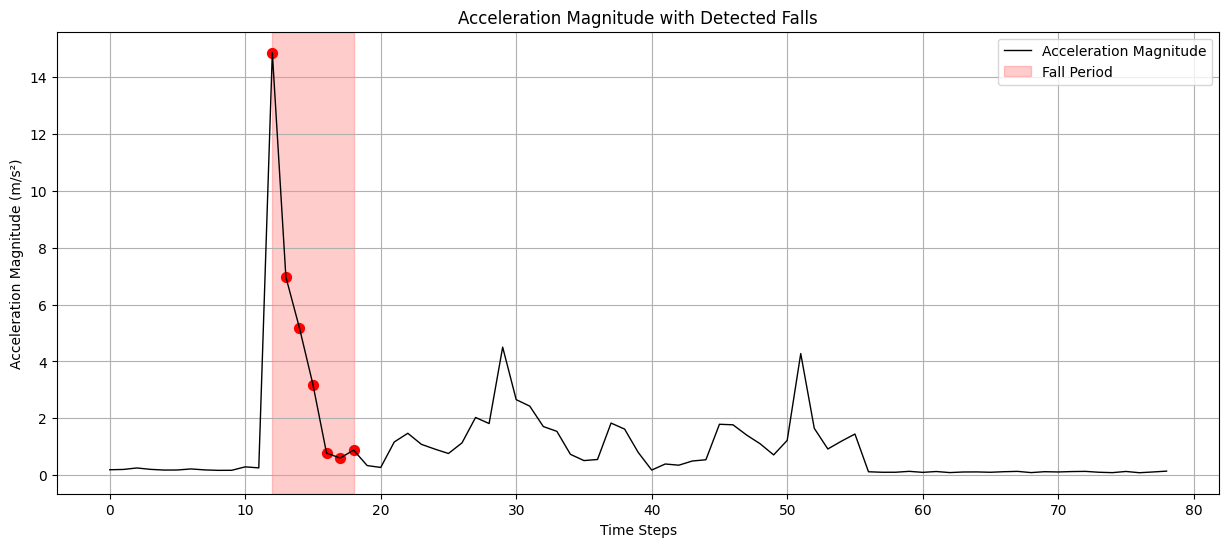


Number of falls detected: 7
Fall detection timestamps: [12 13 14 15 16 17 18]


In [15]:
def detect_fall_threshold(data, 
                        acc_threshold=6,    # Acceleration magnitude threshold
                        jerk_threshold=3,   # Jerk magnitude threshold
                        orientation_threshold=45.0,  # Degrees for roll/pitch
                        window_size=5):       # Window size for delay
    """
    Detect falls using threshold-based algorithm
    
    Parameters:
    data (pd.DataFrame): DataFrame with sensor readings
    acc_threshold (float): Threshold for acceleration magnitude
    jerk_threshold (float): Threshold for jerk magnitude
    orientation_threshold (float): Threshold for roll and pitch angles (degrees)
    window_size (int): Window size for delay analysis
    
    Returns:
    numpy.array: Array of fall detections (0: no fall, 1: fall detected)
    """
    falls = np.zeros(len(data))
    
    for i in range(window_size, len(data)):
        # Get current window
        window = data.iloc[i-window_size:i+1]
        
        # Step 1: Check acceleration magnitude threshold
        if window['acceleration_magnitude'].max() > acc_threshold:
            
            # Step 2: Check jerk after high acceleration
            if window['jerk_magnitude'].max() > jerk_threshold:
                
                # Step 3: Check orientation (roll or pitch)
                max_roll = abs(window['roll'].max())
                max_pitch = abs(window['pitch'].max())
                
                # Convert thresholds from degrees to radians
                angle_thresh_rad = np.radians(orientation_threshold)
                
                if max_roll > angle_thresh_rad or max_pitch > angle_thresh_rad:
                    falls[i] = 1
    
    return falls

def plot_threshold_detections(data, detected_falls, acc_threshold=6.0):
    """
    Plot acceleration magnitude and highlight detected fall periods
    
    Parameters:
    data (pd.DataFrame): DataFrame with sensor readings
    detected_falls (numpy.array): Array of fall detections (0: no fall, 1: fall detected)
    acc_threshold (float): Acceleration threshold used for detection
    """
    plt.figure(figsize=(15, 6))
    
    # Plot acceleration magnitude
    plt.plot(data['acceleration_magnitude'], 
            color='black', 
            label='Acceleration Magnitude', 
            linewidth=1)
    
    # Find continuous fall periods
    fall_indices = np.where(detected_falls == 1)[0]
    if len(fall_indices) > 0:
        # Find breaks in fall indices to separate periods
        breaks = np.where(np.diff(fall_indices) > 1)[0] + 1
        fall_periods = np.split(fall_indices, breaks)
        
        # Plot each fall period as a rectangle
        for period in fall_periods:
            if len(period) > 0:
                start_idx = period[0]
                end_idx = period[-1]
                
                # Create rectangle
                plt.axvspan(start_idx, end_idx, 
                          color='red', 
                          alpha=0.2, 
                          label='Fall Period')
                
                # Plot points during fall
                plt.scatter(period, 
                          data.iloc[period]['acceleration_magnitude'],
                          color='red',
                          s=50)
                
                print(f"Fall period: {start_idx} to {end_idx}")
    
    plt.title('Acceleration Magnitude with Detected Falls')
    plt.xlabel('Time Steps')
    plt.ylabel('Acceleration Magnitude (m/s²)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Print summary
    print(f"\nNumber of falls detected: {len(fall_indices)}")
    if len(fall_indices) > 0:
        print(f"Fall detection timestamps: {fall_indices}")


# First read the CSV file
data = pd.read_csv('dataset/falls/f1.csv')

# Then detect falls
detected_falls = detect_fall_threshold(data)

# Then plot the results
plot_threshold_detections(data, detected_falls, acc_threshold=2.0)

# Example with custom thresholds
detected_falls = detect_fall_threshold(
    data,
    acc_threshold=6,    # Higher acceleration threshold
    jerk_threshold=3,   # Higher jerk threshold
    orientation_threshold=60.0,  # Larger orientation change
    window_size=20        # Longer analysis window
)

Fall period: 31 to 36
Fall period: 57 to 62


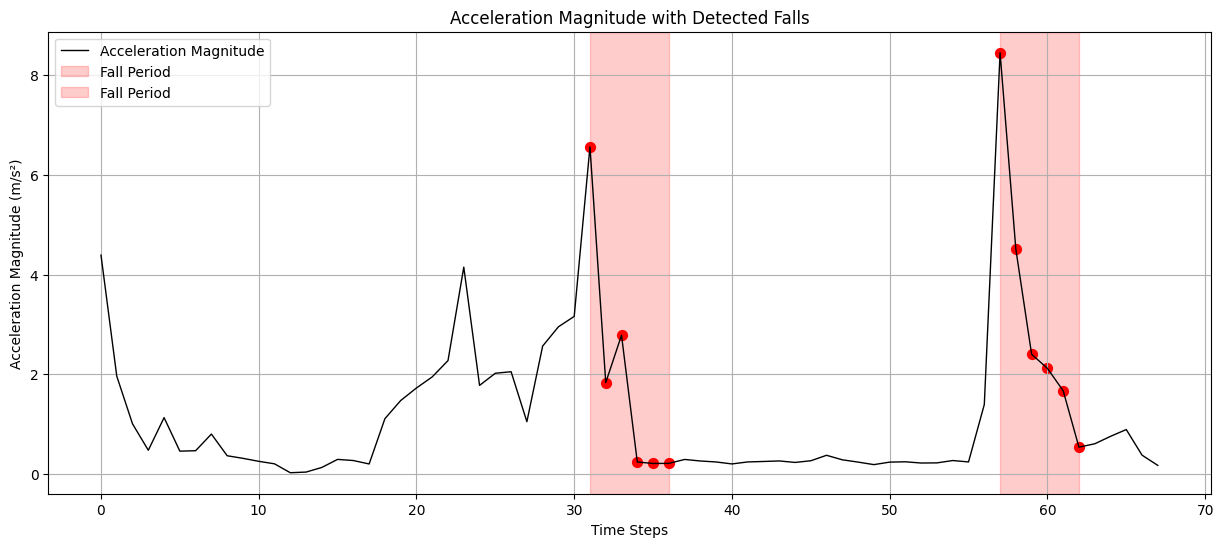


Number of falls detected: 12
Fall detection timestamps: [31 32 33 34 35 36 57 58 59 60 61 62]


In [14]:
data = pd.read_csv('dataset/falls/s1.csv')

# Then detect falls
detected_falls = detect_fall_threshold(data)

# Then plot the results
plot_threshold_detections(data, detected_falls, acc_threshold=2.0)

# Example with custom thresholds
detected_falls = detect_fall_threshold(
    data,
    acc_threshold=6,    # Higher acceleration threshold
    jerk_threshold=3,   # Higher jerk threshold
    orientation_threshold=60.0,  # Larger orientation change
    window_size=20        # Longer analysis window
)

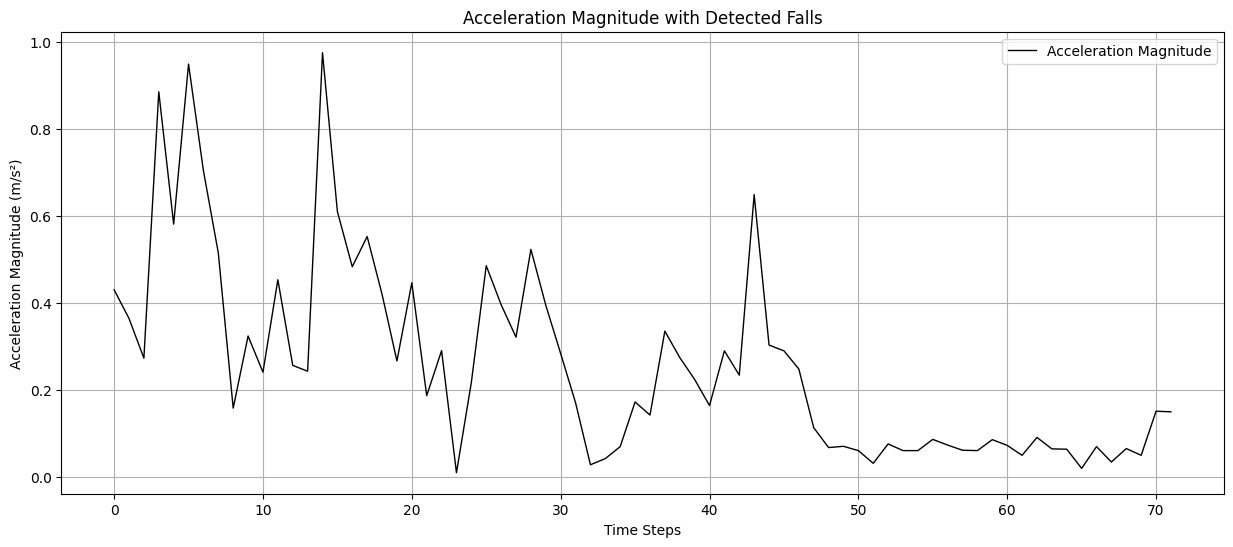


Number of falls detected: 0


In [16]:
data = pd.read_csv('dataset/normal/n1.csv')

# Then detect falls
detected_falls = detect_fall_threshold(data)

# Then plot the results
plot_threshold_detections(data, detected_falls, acc_threshold=2.0)

# Example with custom thresholds
detected_falls = detect_fall_threshold(
    data,
    acc_threshold=6,    # Higher acceleration threshold
    jerk_threshold=3,   # Higher jerk threshold
    orientation_threshold=60.0,  # Larger orientation change
    window_size=20        # Longer analysis window
)

Fall period: 50 to 55


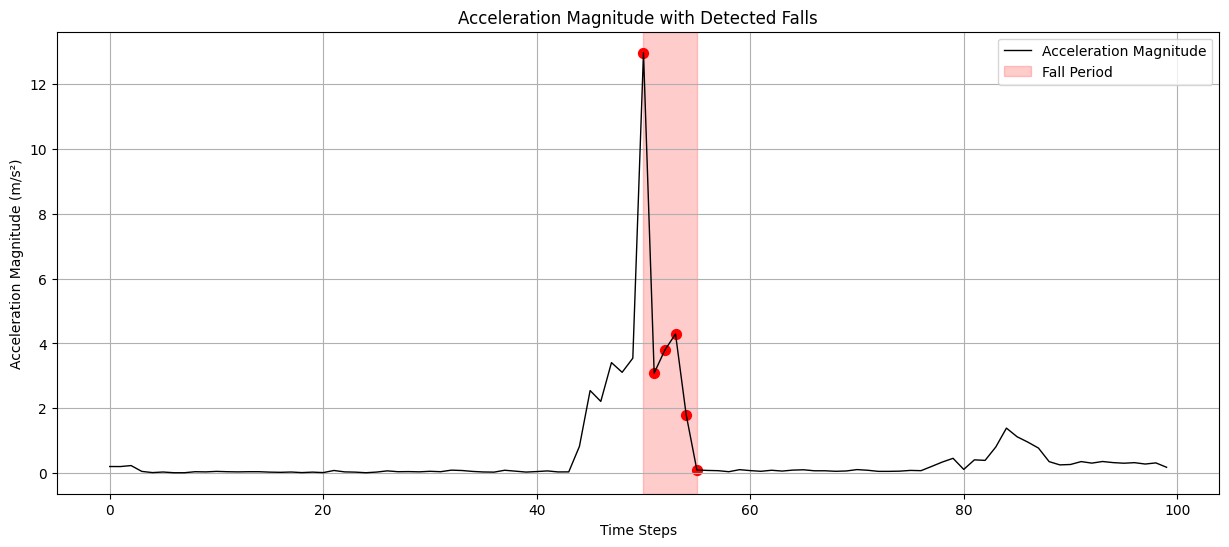


Number of falls detected: 6
Fall detection timestamps: [50 51 52 53 54 55]


In [17]:
data = pd.read_csv('dataset/falls/b1.csv')

# Then detect falls
detected_falls = detect_fall_threshold(data)

# Then plot the results
plot_threshold_detections(data, detected_falls, acc_threshold=2.0)

# Example with custom thresholds
detected_falls = detect_fall_threshold(
    data,
    acc_threshold=6,    # Higher acceleration threshold
    jerk_threshold=3,   # Higher jerk threshold
    orientation_threshold=60.0,  # Larger orientation change
    window_size=20        # Longer analysis window
)